# survey

> This module handles observation targets, survey duration, and other similar functionality. Currently only for MW surveys.

In [ ]:
#| default_exp survey

In [92]:
#| hide
from nbdev.showdoc import *
import numpy as np
from LensCalcPy.pbh import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
from LensCalcPy.parameters import *
import astropy.coordinates as coord
from astropy import units
import matplotlib.pyplot as plt

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
#| export
class Survey:
    """
    A class to represent a survey.
    """

    def __init__(self, 
                 l:float, # Galactic longitude in degrees
                 b: float, # Galactic latitude in degrees
                 source_dist:float, # Distance to observation source in kpc
                 obs_time: float, # Observation time in hours
                 survey_area: float, # Survey area in deg^2
                 n_pbh: int = int(1e2), # Number of PBHs detected
                 n_ffp: int = int(1e4), # Number of FFPs detected
                 ):
     
        self.l = l 
        self.b = b 
        self.source_dist = source_dist 
        self.earth_dist = 8.5 
        self.obs_time = obs_time 
        self.survey_area = survey_area
        self.pbh = None # PBH population
        self.ffp = None # FFP population
        self.n_pbh = n_pbh # Number of PBHs detected
        self.n_ffp = n_ffp # Number of FFPs detected

    def __str__(self) -> str:
        return f"Survey(l={self.l}, b={self.b}, source_dist={self.source_dist}, obs_time={self.obs_time}, survey_area={self.survey_area})"
    __repr__ = __str__
    
    
    def add_pbh(self, 
                m_pbh: float = 1, # mass of each PBH in solar masses
                f_dm: float = 1, # fraction of DM in PBHs
                ):
        """adds a PBH population to the survey"""
        self.pbh = Pbh(m_pbh, f_dm)
        # self.n_pbh = self.num_pbh()
        return
    
    def add_ffp(self,
                mlow: float, # lower mass bound of FFPs in solar masses
                alpha: float, # power law index of FFP mass function
                n_ffp: int = int(1e4), # number of FFPs detected
                ):
        """adds a FFP population to the survey"""
        self.ffp = Ffp(mlow, alpha, )
        self.n_ffp = n_ffp
    
    def num_pbh(self) -> float:

        """returns the number of PBHs in the line of sight"""

        if self.pbh is None:
            raise ValueError("PBH population not defined")
        
         # Obtain survey area, center latitude, and center longitude
        b_radian = b * np.pi / 180  # rad
        l_radian = l * np.pi / 180  # rad

        # Calculate the field of view for the current field
        field_of_view_radius = (self.survey_area / np.pi) ** (1 / 2)

        # Generate an array of heliocentric radii
        # (Just used to numerically integrate the line-of-sight density)
        n_lin = 100000
        r_h_linspace = np.linspace(0, r_max, num=n_lin)

        # Represent the line-of-sight line as galactic coordinates
        galactic_lin = coord.Galactic(
            l=l_radian * units.rad,
            b=b_radian * units.rad,
            distance=r_h_linspace * units.kpc,
        )

        # Transform the line-of-sight into to galactocentric coordinates
        # (Outputs l, b, and distance [units: deg, deg, kpc])
        galacto_lin = galactic_lin.transform_to(
            coord.Galactocentric(representation_type="spherical")
        )

        # Determine dark matter density at all galactocentric radii along the line-of-sight
        rho_lin = density_nfw(galacto_lin.spherical.distance.value)

        # Estimate the total mass within the line-of-sight cylinder [units: M_sun kpc**-2]
        # Total mass = projected line-of-sight density x projected line-of-sight area
        rho_marg_r = np.trapz(rho_lin, dx=(r_max) / n_lin) 

        
        # Determine line-of-sight cylinder radius, assuming small angle approximation [units: kpc]
        r_proj_los_cyl = field_of_view_radius * np.pi / 180 * (r_max)
        # Get projected area of the LOS cylinder [units: kpc**2]
        area_proj_los_cyl = np.pi * r_proj_los_cyl**2
        # Get the total mass within the line-of-sight cylinder
        mass_los_cyl = rho_marg_r * area_proj_los_cyl
        # Get the total number of black holes to randomly draw
        n_pbh = int(np.round(self.pbh.f_dm * mass_los_cyl / self.pbh.m_pbh))
        return n_pbh

    def get_lens_masses(self) -> np.ndarray:
        """returns an array of lens masses"""
        if self.pbh is None:
            raise ValueError("PBH population not defined")
        if self.ffp is None:
            raise ValueError("FFP population not defined")
        print(len(self.ffp.sample_masses), self.n_pbh)
        return np.concatenate((np.ones(self.n_pbh) * self.pbh.m_pbh, self.ffp.sample_masses))
    
    def get_crossing_times(self) -> np.ndarray:
        """returns an array of crossing times"""
        if self.pbh is None:
            raise ValueError("PBH population not defined")
        if self.ffp is None:
            raise ValueError("FFP population not defined")
        
        t_es = np.logspace(-1, 3, 100)

        self.pbh.differential_rate(t_es)
        


In [120]:
m_pbh = 1e-2
f_dm = 1
mlow = 1e-5
alpha = 2

In [124]:
s = Survey(l, b, ds, obsTime, survey_area, n_pbh=500, n_ffp=1000)
s

Survey(l=1.0, b=-1.03, source_dist=9.0, obs_time=7, survey_area=0.16)

In [125]:
s.add_pbh(m_pbh, f_dm)
s.add_ffp(mlow, alpha)
lens_masses = s.get_lens_masses()

10000 500


In [131]:
num_bins = 10
bin_edges = np.logspace(np.log10(min(lens_masses)), np.log10(max(lens_masses)), num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

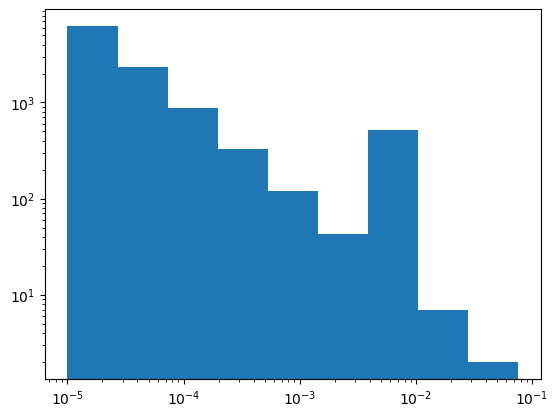

In [132]:
plt.hist(lens_masses, bins=bin_edges)
plt.xscale("log")
plt.yscale("log")

In [ ]:
# Generate example observed counts with a bump
a = 200
index = -2
bump_position = 6
bump_height = 20

min_bin = 1
max_bin = 10
bin_edges = np.linspace(min_bin,max_bin,10)  # Assuming bins from -6 to -2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

observed_counts = generate_observed_counts_with_bump(bin_centers, a, index, bump_position, bump_height)

optimized_params_bump = get_MLE_params(bin_centers, observed_counts)
expected_counts_opt = generate_observed_counts_with_bump(bin_centers, *optimized_params_bump)

print("Optimized parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2f}, bump_height = {:.2f}".format(*optimized_params_bump))
print("True parameters: a = {:.2f}, index = {:.2f}, bump_position = {:.2e}, bump_height = {:.2f}".format(a, index, bump_position, bump_height))plt.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()